# T4: Neural IBM1 with collocations and latent gate

Neural IBM 1 with additional stochastic collocations (Section 2.3 of the notebook).

Here we made the collocation variable $s$ continuous. You can interpret $S$ as a random variable over gate values.

In [64]:
# first run a few imports:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
from pprint import pprint
import pickle
from utils import smart_reader, bitext_reader
from vocabulary import OrderedCounter, Vocabulary 
from utils import iterate_minibatches, prepare_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

In [81]:
# the paths to our training and validation data, English side
train_e_path = 'data/training/hansards.36.2.e.gz'
train_f_path = 'data/training/hansards.36.2.f.gz'
dev_e_path = 'data/validation/dev.e.gz'
dev_f_path = 'data/validation/dev.f.gz'
dev_wa = 'data/validation/dev.wa.nonullalign'
test_e_path = 'data/test/test.e.gz'
test_f_path = 'data/test/test.f.gz'
test_wa = 'data/test/test.wa.nonullalign'

These are the vocabularies that we use further on.

In [82]:
# Using only 1000 words will result in many UNKs, but
# it will make training a lot faster. 
# If you have a fast computer, a GPU, or a lot of time,
# try with 10000 instead.
max_tokens=1000

corpus_e = smart_reader(train_e_path)    
vocabulary_e = Vocabulary(corpus=corpus_e, max_tokens=max_tokens)
pickle.dump(vocabulary_e, open("vocabulary_e.pkl", mode="wb"))

corpus_f = smart_reader(train_f_path)    
vocabulary_f = Vocabulary(corpus=corpus_f, max_tokens=max_tokens)
pickle.dump(vocabulary_f, open("vocabulary_f.pkl", mode="wb"))

## T4 model

We import the NeuralIBM1Model from T4.py and NeuralIBM1Trainer from T4trainer.py

In [85]:
from T4 import VAE
from T4trainer import VAETrainer

In [86]:
tf.reset_default_graph()

with tf.Session() as sess:
    #   with tf.device("/cpu:0"):   

    batch_size=64
    max_length=30

    model = VAE(vocabulary=vocabulary_e, batch_size=batch_size, 
              emb_dim=64, rnn_dim=128, z_dim=64, context='gate')
    trainer = VAETrainer(model, train_e_path, train_f_path,
                         dev_e_path, dev_f_path, dev_wa,
                         test_e_path, test_f_path, test_wa,
                         num_epochs=10, 
                         batch_size=batch_size, max_length=max_length,
                         lr=0.001, lr_decay=0.0, session=sess,
                         max_num=2000) # small training corpus just to make testing new code easier

    print("Initializing variables..")
    sess.run(tf.global_variables_initializer())

    print("Training started..")
    results = trainer.train()
    dev_AERs, test_AERs, train_ELBOs, dev_ELBOs = results


Size: 1668
Initializing variables..
Training started..
Epoch 1 epoch_loss 1398.9639916053186
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Epoch 2 epoch_loss 628.17213674692
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Epoch 3 epoch_loss 444.9261451134315
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Epoch 4 epoch_loss 372.7253230168269
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Epoch 5 epoch_loss 332.07383728027344
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Epoch 6 epoch_loss 306.56825197660004
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Epoch 7 epoch_loss 287.4197868934044
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Epoch 8 epoch_loss 2

### Plots

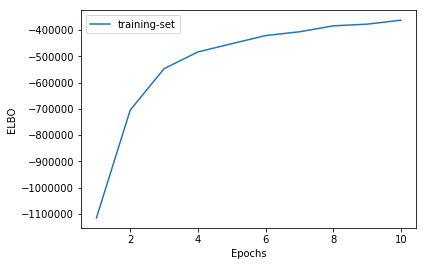

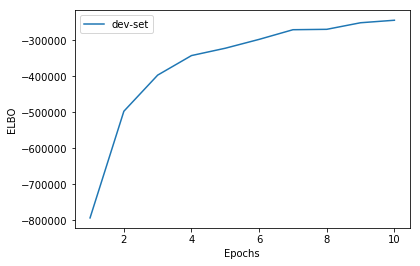

In [87]:
# plotting
import matplotlib.pyplot as plt

# handles = []
# ax1 = plt.plot(range(1, len(dev_AERs)+1), dev_AERs, label='dev-set')
# handles.extend(ax1)
# ax2 = plt.plot(range(1, len(test_AERs)+1), test_AERs, label='test-set')
# handles.extend(ax2)
# plt.legend(handles=handles)
# plt.xlabel('Epochs')
# plt.ylabel('AER')
# plt.show()
# plt.clf()

handles = []
ax1 = plt.plot(range(1, len(train_ELBOs)+1), train_ELBOs, label='training-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(dev_ELBOs)+1), dev_ELBOs, label='dev-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.show()
plt.clf()

## Neural IBM1 withouth French context

For comparison purposes we include the results of the originial neural IBM1.

In [33]:
from neuralibm1 import NeuralIBM1Model
from neuralibm1trainer import NeuralIBM1Trainer

In [34]:
tf.reset_default_graph()


with tf.Session() as sess:

    # some hyper-parameters
    # tweak them as you wish
    batch_size=10  # on CPU, use something much smaller e.g. 1-16
    max_length=30
    lr = 0.001
    lr_decay = 0.0  # set to 0.0 when using Adam optimizer (default)
    emb_dim = 64
    mlp_dim = 128

    # our model
    model = NeuralIBM1Model(
        x_vocabulary=vocabulary_e, y_vocabulary=vocabulary_f, 
        batch_size=batch_size, emb_dim=emb_dim, mlp_dim=mlp_dim, session=sess)

    # our trainer
    trainer = NeuralIBM1Trainer(
        model, train_e_path, train_f_path, 
        dev_e_path, dev_f_path, dev_wa,
        test_e_path, test_f_path, test_wa,
        num_epochs=10, batch_size=batch_size, 
        max_length=max_length, lr=lr, lr_decay=lr_decay, session=sess,
        max_num=10000) # small training corpus just to make testing new code easier

    # now first TF needs to initialize all the variables
    print("Initializing variables..")
    sess.run(tf.global_variables_initializer())


    # now we can start training!
    print("Training started..")
    results = trainer.train()
    dev_AERs, test_AERs, train_likelihoods, dev_likelihoods = results

Training with B=10 max_length=30 lr=0.001 lr_decay=0.0
Initializing variables..
Training started..
Shuffling training data
Iter   100 loss 66.535721 accuracy 0.22 lr 0.001000
Iter   200 loss 58.521881 accuracy 0.22 lr 0.001000
Iter   300 loss 64.783844 accuracy 0.20 lr 0.001000
Iter   400 loss 43.832909 accuracy 0.24 lr 0.001000
Iter   500 loss 55.865246 accuracy 0.20 lr 0.001000
Iter   600 loss 69.351669 accuracy 0.21 lr 0.001000
Iter   700 loss 54.295448 accuracy 0.24 lr 0.001000
Epoch 1 loss 64.711381 accuracy 0.19 val_aer 0.65 val_acc 0.19
Computing training-set likelihood
Computing dev-set likelihood
Model saved in file: model.ckpt
Shuffling training data
Iter   100 loss 71.635216 accuracy 0.17 lr 0.001000
Iter   200 loss 75.882431 accuracy 0.16 lr 0.001000
Iter   300 loss 60.810463 accuracy 0.15 lr 0.001000
Iter   400 loss 70.482773 accuracy 0.22 lr 0.001000
Iter   500 loss 61.605980 accuracy 0.12 lr 0.001000
Iter   600 loss 56.401680 accuracy 0.22 lr 0.001000
Iter   700 loss 68.

### Plots

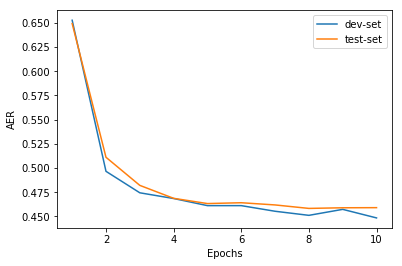

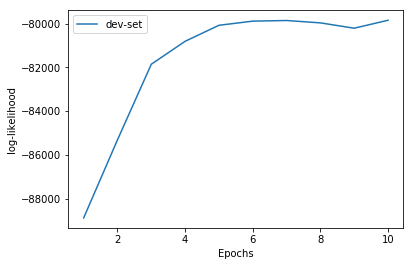

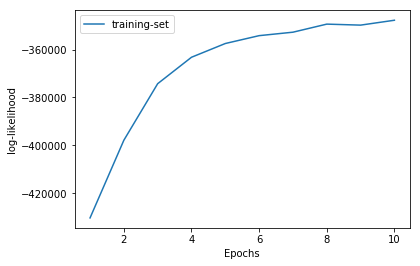

In [35]:
# plotting
import matplotlib.pyplot as plt

handles = []
ax1 = plt.plot(range(1, len(dev_AERs)+1), dev_AERs, label='dev-set')
handles.extend(ax1)
ax2 = plt.plot(range(1, len(test_AERs)+1), test_AERs, label='test-set')
handles.extend(ax2)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('AER')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(train_likelihoods)+1), train_likelihoods, label='training-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('log-likelihood')
plt.show()
plt.clf()

handles = []
ax1 = plt.plot(range(1, len(dev_likelihoods)+1), dev_likelihoods, label='dev-set')
handles.extend(ax1)
plt.legend(handles=handles)
plt.xlabel('Epochs')
plt.ylabel('log-likelihood')
plt.show()
plt.clf()